In [1]:
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.loader import DataLoader

import cider
import models
import utils

import nci
import ba
import mutag

In [2]:
train_set = mutag.Mutagenicity(mode="training")
train_set_mini = train_set[0:8]

train_loader = DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
train_loader_mini = DataLoader(
    train_set_mini,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

In [3]:
hidden_channels1 = 128
hidden_channels2 = 128
hidden_channels3 = 128

device = torch.device('cuda:3')

task_model_para_path = "./params/mutag_net.pt"
explainer_para_path = "./params/explainer_mutag.ckpt"

In [4]:
task_model = models.GcnEncoderGraph(
    input_dim=train_set.num_features,
    hidden_dim=50,
    embedding_dim=10,
    num_layers=3,
    pred_hidden_dims=[10, 10],
    label_dim=2,
)

explainer = cider.CIDER(
    train_set.num_features,
    hidden_channels1=hidden_channels1,
    hidden_channels2=hidden_channels2,
    hidden_channels3=hidden_channels3,
    task_model=task_model,
)

In [5]:
explainer.to(device)

CIDER(
  (gcn_shared): Sequential(
    (0): GCNConv(14, 128)
  )
  (gcn_mu_causal): GCNConv(128, 128)
  (gcn_mu_non_causal): GCNConv(128, 128)
  (gcn_logvar_causal): GCNConv(128, 128)
  (gcn_logvar_non_causal): GCNConv(128, 128)
  (decoder_causal): InnerProductDecoderMLP(
    (fc_layers): ModuleList()
  )
  (decoder_non_causal): InnerProductDecoderMLP(
    (fc_layers): ModuleList()
  )
  (task_model): GcnEncoderGraph(
    (conv_first): GCNConv(14, 50)
    (conv_block): ModuleList(
      (0): GCNConv(50, 50)
    )
    (conv_last): GCNConv(50, 10)
    (act): ReLU()
    (pred_model): Sequential(
      (0): Linear(in_features=110, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=2, bias=True)
    )
  )
  (relu): ReLU()
)

In [6]:
explainer.load_state_dict(torch.load(explainer_para_path))

<All keys matched successfully>

In [34]:
task_model.load_state_dict(torch.load('params/mutag_net.pt'))

<All keys matched successfully>

In [35]:
utils.evaluate_graphs_accuracy(train_loader, task_model, device)

0.8261911896913395

In [8]:
x = train_set_mini[0].x.to(device)
edge_index = train_set_mini[0].edge_index.to(device)

In [9]:
explainations = explainer.get_explainations(x, edge_index, device=device)

In [10]:
explainations

{'0.9': Data(x=[29, 14], edge_index=[2, 46]),
 '0.8': Data(x=[29, 14], edge_index=[2, 34]),
 '0.7': Data(x=[29, 14], edge_index=[2, 24]),
 '0.6': Data(x=[29, 14], edge_index=[2, 18]),
 '0.5': Data(x=[29, 14], edge_index=[2, 12]),
 '0.4': Data(x=[29, 14], edge_index=[2, 8]),
 '0.3': Data(x=[29, 14], edge_index=[2, 6]),
 '0.2': Data(x=[29, 14], edge_index=[2, 4]),
 '0.1': Data(x=[29, 14], edge_index=[2, 4])}

In [99]:
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

index = 0

explainations = explainer.get_explainations(train_set_mini[index].x.to(device), train_set_mini[index].edge_index.to(device), device=device)
explaination = to_networkx(explainations['0.1'])
G = torch_geometric.utils.to_networkx(train_set_mini[index])
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=[i for i in range(train_set_mini[index].num_nodes)], node_color='green', node_size=300)

nx.draw_networkx_edges(G, pos, width=2, edge_color='grey')

nx.draw_networkx_edges(G, pos, edgelist=explaination.edges, width=5)

plt.axis('off')
plt.show()
plt.clf()

AttributeError: 'Explainer' object has no attribute 'get_explainations'

In [79]:
task_model(
    train_set_mini[index].x.to(device),
    train_set_mini[index].edge_index.to(device)
)

tensor([[ 0.5646, -0.4532]], device='cuda:3', grad_fn=<AddmmBackward0>)

In [78]:
task_model(
    explainations['0.3'].x,
    explainations['0.3'].edge_index
)

tensor([[ 2.2658, -1.9204]], device='cuda:3', grad_fn=<AddmmBackward0>)

In [50]:
train_set_mini[index].y

tensor([0])

In [92]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=task_model.cpu(),
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
    ),
)

In [100]:
explanation = explainer(train_set_mini[index].x.cpu(), train_set_mini[index].edge_index.cpu())

In [101]:
explaination.edges

OutEdgeView([(6, 9), (7, 9), (9, 6), (9, 7)])

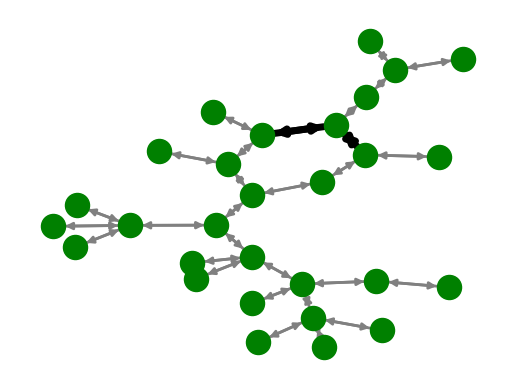

<Figure size 640x480 with 0 Axes>

In [96]:
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

index = 0

# explainations = explainer.get_explainations(train_set_mini[index].x.to(device), train_set_mini[index].edge_index.to(device), device=device)
# explaination = to_networkx(explainations['0.1'])
G = torch_geometric.utils.to_networkx(train_set_mini[index])
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=[i for i in range(train_set_mini[index].num_nodes)], node_color='green', node_size=300)

nx.draw_networkx_edges(G, pos, width=2, edge_color='grey')

nx.draw_networkx_edges(G, pos, edgelist=explaination.edges, width=5)

plt.axis('off')
plt.show()
plt.clf()